In [1]:
# Importing TensorFlow

import tensorflow as tf

# import matplotlib.pyplot as plt
# import matplotlib.ticker as ticker




# import numpy as np

# import time

# Utilities And Downloads

We use `tf.keras.utils.get_file` to download the English to Spanish dataset hosted by Google. We define the file name where the script will save the dataset

In [2]:
# Download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip',
    origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)
print(path_to_zip)

2646016/2638744 [==============================] - 0s 0us/step
/root/.keras/datasets/spa-eng.zip


In [3]:
print(type(path_to_zip))

<class 'str'>


We set our path_to_file as the text file which contains our complete dataset

In [4]:
import os
import re

In [5]:
path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"
print(path_to_file)

/root/.keras/datasets/spa-eng/spa.txt


# Cleaner functions



In [6]:
import unicodedata

In [7]:
def unicode_to_ascii(s):
  """
  Converts unicode Data to its Ascii equivalent

  Args:
    s: (str) input sentence

  Returns:
    converted data
  """
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

In [8]:
def preprocess_sentence(w):
  """
  Preproccesses a sentence

  Args:
    w: (str) input sentence

  Returns:
    preproccessed sentence
  """
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [9]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [10]:
import io

In [11]:
def create_dataset(path, num_examples):
  """
  Creating the pair wise dataset

  Args:
    path: (str) The txt file containing the data

  Returns:
    A tuple of pair of sentences
  """
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [12]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [13]:
def tokenize(lang):
  """
  Tokenizing the dataset

  Args:
    lang: (list) Dataset on a particular language

  Returns:
    tensor: The words belonging to the vocabulary in integer format
    lang_tokenizer: The tokenizer of the particular language
  """
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

### Limit the size of the dataset to experiment faster (optional)

Training on the complete dataset of >100,000 sentences will take a long time. To train faster, we can limit the size of the dataset to 30,000 sentences (of course, translation quality degrades with less data):

In [14]:
def load_dataset(path, num_examples=None):
  """
  Load the full dataset

  Args:
    path: (str) Path where the dataset is stored

  Returns:
    input_tensor: Our input language data in tensor format
    target_tensor: Our output language data in tensor format
    inp_lang_tokenizer: Tokenizer belonging to the input language
    targ_lang_tokenizer: Tokenizer belonging to the output language
  """
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path , num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [15]:
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples = 30000)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [18]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [19]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
3999 ----> tomemos
15 ----> un
582 ----> taxi
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
46 ----> let
11 ----> s
94 ----> take
9 ----> a
773 ----> taxi
3 ----> .
2 ----> <end>


In [20]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 512
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [21]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([512, 16]), TensorShape([512, 11]))

In [22]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.bidirection = tf.keras.layers.Bidirectional(self.gru, merge_mode='sum' )

  def call(self, x, hidden_fd, hidden_bd):
    x = self.embedding(x)
    output, fd_state, bd_state = self.bidirection(x, initial_state = [hidden_fd, hidden_bd])
    return output, fd_state, bd_state

  def initialize_hidden_state(self):
    return [tf.zeros((self.batch_sz, self.enc_units)) for i in range(2)]

In [23]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden_fwd, sample_bd_hidden = encoder.initialize_hidden_state()
sample_output, sample_fd_hidden, sample_bd_hidden = encoder(example_input_batch, sample_hidden_fwd, sample_bd_hidden )
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden_fwd.shape))

Encoder output shape: (batch size, sequence length, units) (512, 16, 1024)
Encoder Hidden state shape: (batch size, units) (512, 1024)


In [24]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # Query Decoder Hidden state, Values belongs is the Encoder output
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)
    
    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [25]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [26]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden_fwd, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (512, 4935)


In [27]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [28]:
@tf.function
def train_step(inp, targ, enc_hidden_fwd, enc_hidden_bck):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden_fwd, _ = encoder(inp, enc_hidden_fwd, enc_hidden_bck)

    dec_hidden = enc_hidden_fwd

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [29]:
import time

In [31]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden_fwd, enc_hidden_bck = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden_fwd, enc_hidden_bck)
    total_loss += batch_loss

    if batch % 10 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.9242
Epoch 1 Batch 10 Loss 1.9155
Epoch 1 Batch 20 Loss 1.9340
Epoch 1 Batch 30 Loss 1.8400
Epoch 1 Batch 40 Loss 1.8437
Epoch 1 Loss 1.8817
Time taken for 1 epoch 11.47627568244934 sec

Epoch 2 Batch 0 Loss 1.7594
Epoch 2 Batch 10 Loss 1.7172
Epoch 2 Batch 20 Loss 1.7321
Epoch 2 Batch 30 Loss 1.6529
Epoch 2 Batch 40 Loss 1.6343
Epoch 2 Loss 1.6692
Time taken for 1 epoch 11.49654221534729 sec

Epoch 3 Batch 0 Loss 1.5860
Epoch 3 Batch 10 Loss 1.5215
Epoch 3 Batch 20 Loss 1.5211
Epoch 3 Batch 30 Loss 1.4951
Epoch 3 Batch 40 Loss 1.4960
Epoch 3 Loss 1.5163
Time taken for 1 epoch 11.444029331207275 sec

Epoch 4 Batch 0 Loss 1.4389
Epoch 4 Batch 10 Loss 1.4112
Epoch 4 Batch 20 Loss 1.4110
Epoch 4 Batch 30 Loss 1.4110
Epoch 4 Batch 40 Loss 1.4215
Epoch 4 Loss 1.4130
Time taken for 1 epoch 11.427672624588013 sec

Epoch 5 Batch 0 Loss 1.3007
Epoch 5 Batch 10 Loss 1.3286
Epoch 5 Batch 20 Loss 1.3145
Epoch 5 Batch 30 Loss 1.3079
Epoch 5 Batch 40 Loss 1.3012
Epoch 5 Loss 1

In [52]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden_fwd = tf.zeros((1, units))
  hidden_bck = tf.zeros((1, units))
  enc_out, enc_hidden, _ = encoder(inputs, hidden_fwd, hidden_bck)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [46]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [49]:
def translate(sentence):

  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [ ]:
translate(u'hace mucho frio aqui.')

Input: <start> esta es mi vida . <end>
Predicted translation: this is my friend . <end> 


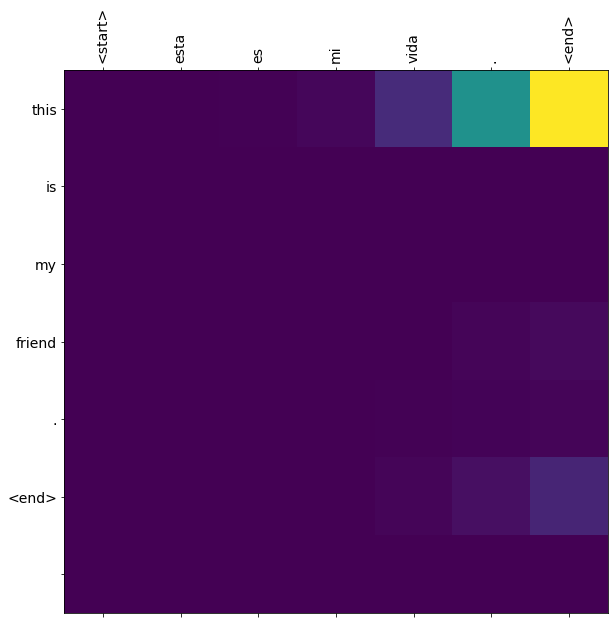

In [53]:
translate(u'esta es mi vida.')